# Schelling and segregation in online groups 

This paper takes the view that polarization can be driven by the interaction between segregation of opinion, and opinion interaction.

The main research question is: _what mechanisms can we suggest that would explain the hypothesis that the internet generates higher levels of polarization?_


Social media increases the sorting between people of different opinions in various dimensions. Because of this, the homogeneity increases. Substantial social scientific research implies that this in turn leads to polarization, through a number of suggested mechanisms.

The modeling philosophy behind this is to use many small models as support for a theoretical argument, and to show the existence of a broad and stable emergent phenomenon.

Hence, we first look at how various opinions results in a sorting of the interaction structure. The departure point is Schelling's segregation model. We want to explore under what conditions this phenomenon occurs, and whether it has relevance for e.g. online interaction.

0.12028560557195259


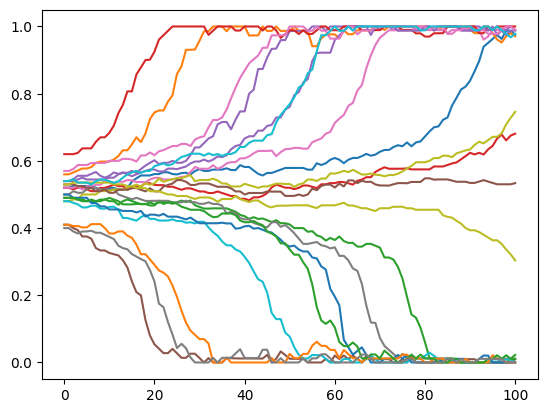

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter

class multiple_communities:

    def __init__(self,nragents=100,nrcommunities=20,nrinteractors=10,threshold=0.1):

        self.nragents = nragents
        self.nrcommunities = nrcommunities
        self.nrinteractors = nrinteractors
        self.threshold = threshold
        self.statistics = [[] for i in range(self.nrcommunities)]
    
    def initiate(self):
        self.communities = {i:np.random.randint(2, size=(self.nragents)) for i in range(self.nrcommunities)}
        self.update_statistics()

    def user_interactions(self):
        # Build a flat list of all users with their (community_id, user_index)
        all_users = [(comm_id, idx) for comm_id, users in self.communities.items() for idx in range(len(users))]
        
        # Skip if no users at all
        if not all_users:
            return

        # Select a uniformly random user across all communities
        comm_id, user_idx = random.choice(all_users)
        user_opinion = self.communities[comm_id][user_idx]

        # Skip if not enough interactors in the same community
        if len(self.communities[comm_id]) < self.nrinteractors:
            return

        # Sample interactors from the same community
        interactors = random.sample(range(len(self.communities[comm_id])), self.nrinteractors)
        interactor_opinions = [self.communities[comm_id][j] for j in interactors]
        counter = Counter(interactor_opinions)
        fraction = counter[user_opinion] / len(interactors)

        # Possibly move to another community
        if fraction <= self.threshold:
            other_communities = list(self.communities.keys())
            other_communities.remove(comm_id)
            if not other_communities:
                return  # No other communities to move to
            new_com = random.choice(other_communities)
            self.communities[new_com] = np.append(self.communities[new_com], self.communities[comm_id][user_idx])
            self.communities[comm_id] = np.delete(self.communities[comm_id], user_idx)
            
    def step(self):
        self.user_interactions()

        self.add_noise()
        

    def update_statistics(self):
        for i in self.communities.keys(): 
            self.statistics[i].append(Counter(self.communities[i])[0]/len(self.communities[i]))

    def run(self,nr_steps,statistics_resolution=100):
        statistics_frequency = int(nr_steps / statistics_resolution)
        for step_iter in range(nr_steps):
            self.step()
            if step_iter % statistics_frequency == 0:
                self.update_statistics()

        return self.calculate_segregation()
                    
    def plot_statistics(self):
        for i in self.communities.keys(): 
            plt.plot(self.statistics[i])
        return self.calculate_segregation()
    
    def calculate_segregation(self):
        total_users = 0
        total_mixed_fraction = 0.0
        
        for community in self.communities.values():
            n = len(community)
            if n <= 1:
                continue  # Skip communities with 0 or 1 user
            
            # For each user, compute fraction of other users that are of different type
            for i in range(n):
                user_opinion = community[i]
                others = np.delete(community, i)
                diff_count = np.sum(others != user_opinion)
                mixed_fraction = diff_count / (n - 1)
                total_mixed_fraction += mixed_fraction
                total_users += 1
        
        if total_users == 0:
            return 0.0
        
        # Average fraction of different-type neighbors
        return total_mixed_fraction / total_users


model = multiple_communities()
model.initiate()
seg = model.run(100000)
model.plot_statistics()
print(seg)


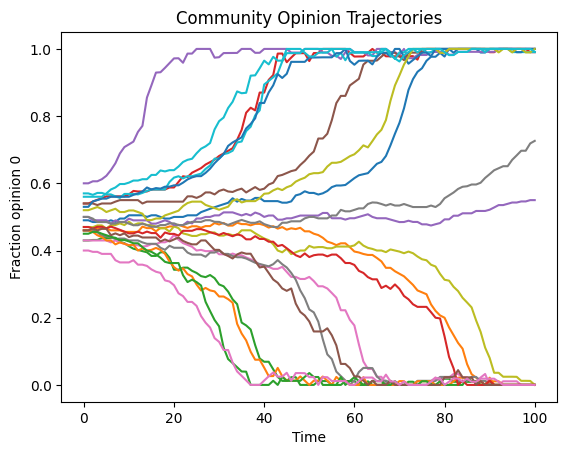

Segregation score: 0.05633884101510001


In [33]:
import matplotlib.pyplot as plt
import numpy as np
import random


# Same code, but optimized for speed
class MultipleCommunities:
    def __init__(self, nragents=100, nrcommunities=20, nrinteractors=10, threshold=0.1):
        self.nragents = nragents
        self.nrcommunities = nrcommunities
        self.nrinteractors = nrinteractors
        self.threshold = threshold
        self.statistics = [[] for _ in range(self.nrcommunities)]

    def initiate(self):
        # Each community is an array of agent opinions (0 or 1)
        self.communities = {i: np.random.randint(2, size=self.nragents) for i in range(self.nrcommunities)}
        self.update_statistics()

    def user_interactions(self):
        # Efficiently sample a random user across all communities (proportional sampling)
        sizes = [len(users) for users in self.communities.values()]
        total = sum(sizes)
        if total == 0:
            return  # No users
        community_ids = list(self.communities.keys())
        comm_id = random.choices(community_ids, weights=sizes, k=1)[0]
        users = self.communities[comm_id]
        if len(users) < self.nrinteractors:
            return  # Not enough interactors in this community
        user_idx = random.randrange(len(users))
        user_opinion = users[user_idx]
        # Efficient sampling of interactors (excluding focal user is not strictly necessary)
        interactors = random.sample(range(len(users)), self.nrinteractors)
        interactor_opinions = users[interactors]
        fraction_same = np.count_nonzero(interactor_opinions == user_opinion) / self.nrinteractors
        # Move only if too few of the same opinion
        if fraction_same <= self.threshold:
            other_communities = [cid for cid in self.communities if cid != comm_id]
            if not other_communities:
                return
            new_com = random.choice(other_communities)
            # Move user
            self.communities[new_com] = np.append(self.communities[new_com], users[user_idx])
            self.communities[comm_id] = np.delete(users, user_idx)

    def step(self):
        self.user_interactions()
        self.add_noise()

    def update_statistics(self):
        # Track fraction of opinion 0 in each community (fast numpy version)
        for i in self.communities.keys():
            community = self.communities[i]
            if len(community) > 0:
                self.statistics[i].append(np.sum(community == 0) / len(community))
            else:
                self.statistics[i].append(0)

    def run(self, nr_steps, statistics_resolution=100):
        statistics_frequency = max(1, int(nr_steps / statistics_resolution))
        for step_iter in range(nr_steps):
            self.step()
            if step_iter % statistics_frequency == 0:
                self.update_statistics()
        return self.calculate_segregation()

    def plot_statistics(self):
        for stat in self.statistics:
            plt.plot(stat)
        plt.xlabel('Time')
        plt.ylabel('Fraction opinion 0')
        plt.title('Community Opinion Trajectories')
        plt.show()
        return self.calculate_segregation()

    def calculate_segregation(self):
        # Vectorized segregation: for each community, use type counts
        total_mixed = 0.0
        total_users = 0
        for community in self.communities.values():
            n = len(community)
            if n <= 1:
                continue
            count0 = np.sum(community == 0)
            count1 = n - count0
            # Users of type 0: fraction of others that are 1
            if count0 > 0:
                total_mixed += count0 * (count1 / (n - 1))
                total_users += count0
            # Users of type 1: fraction of others that are 0
            if count1 > 0:
                total_mixed += count1 * (count0 / (n - 1))
                total_users += count1
        if total_users == 0:
            return 0.0
        return total_mixed / total_users



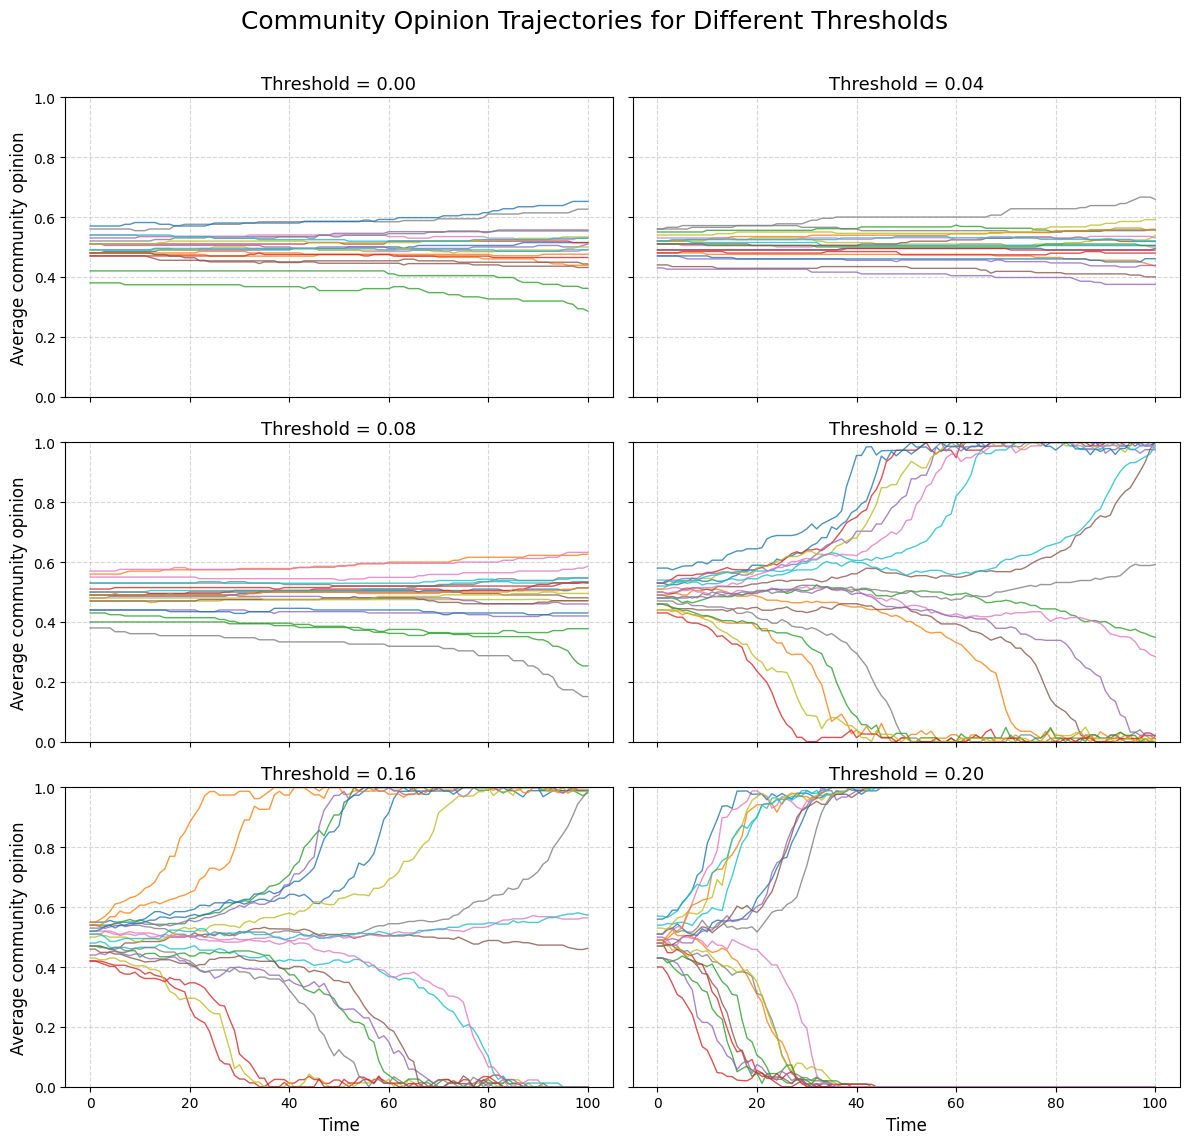

In [43]:
# Execute several runs, varying theta

threshold_values = np.linspace(0, 0.2, 6)
nr_steps = 100_000
statistics_resolution = 100

fig, axes = plt.subplots(3, 2, figsize=(12, 12), sharex=True, sharey=True)
axes = axes.flatten()

for i, threshold in enumerate(threshold_values):
    model = MultipleCommunities(threshold=threshold, noise=0)
    model.initiate()
    model.run(nr_steps, statistics_resolution=statistics_resolution)
    
    ax = axes[i]
    for stat in model.statistics:
        ax.plot(stat, linewidth=1, alpha=0.8)
    ax.set_title(f"Threshold = {threshold:.2f}", fontsize=13)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_ylim([0, 1])
    if i % 2 == 0:
        ax.set_ylabel("Average community opinion", fontsize=12)
    if i >= 4:
        ax.set_xlabel("Time", fontsize=12)

# Hide any unused subplots if the grid is not full
for j in range(len(threshold_values), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Community Opinion Trajectories for Different Thresholds', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])  # make room for suptitle

# Save combined figure
fig.savefig('community_trajectories_grid.png', dpi=300)
fig.savefig('community_trajectories_grid.pdf')

plt.show()

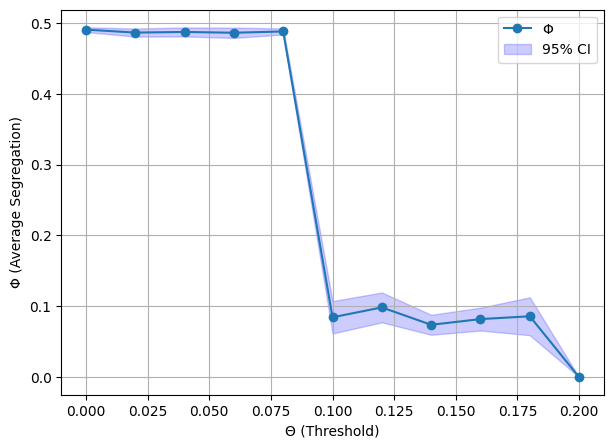

In [69]:
# Examine change over theta
threshold_values = np.linspace(0, 0.2, 11)  # 0, 0.02, ..., 0.2
runs_per_threshold = 10
nr_steps = 100_000

avg_segregation = []
ci_lower = []
ci_upper = []

for threshold in threshold_values:
    segs = []
    for run in range(runs_per_threshold):
        model = MultipleCommunities(threshold=threshold,noise=0)
        model.initiate()
        seg_final = model.run(nr_steps, statistics_resolution=100)
        segs.append(seg_final)
    segs = np.array(segs)
    mean = np.mean(segs)
    std = np.std(segs, ddof=1)
    se = std / np.sqrt(runs_per_threshold)
    ci = 1.96 * se
    avg_segregation.append(mean)
    ci_lower.append(mean - ci)
    ci_upper.append(mean + ci)

# Plotting with confidence intervals
plt.figure(figsize=(7, 5))
plt.plot(threshold_values, avg_segregation, marker='o', label='Φ')
plt.fill_between(threshold_values, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% CI')
plt.xlabel('Θ (Threshold)')
plt.ylabel('Φ (Average Segregation)')
# plt.title('Average Segregation as a Function of Threshold')
plt.grid(True)
plt.legend()
plt.savefig(f'segregation_by_threshold.png', dpi=300)
plt.savefig(f'segregation_by_threshold.pdf')
plt.show()

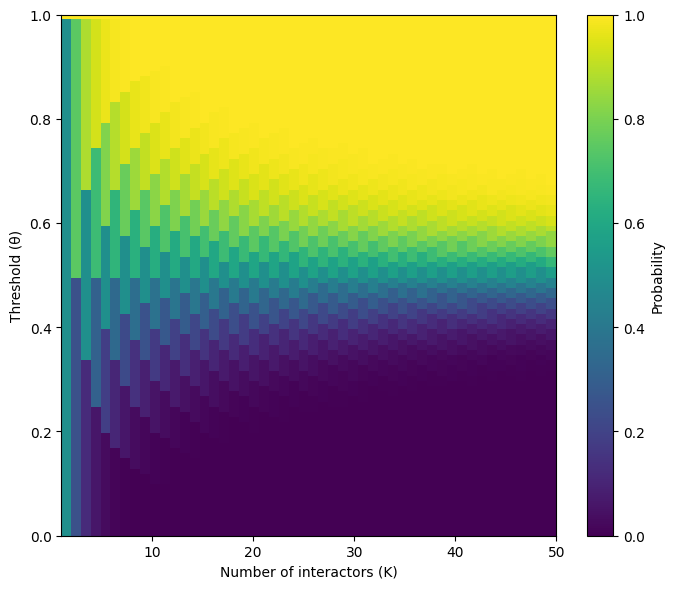

In [66]:
# Mathematical analysis of theta and k
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Define a range of K (number of tosses) and P (percentage threshold for heads)
K_values = np.arange(1, 51)  # Number of coin tosses from 1 to 50
P_percentages = np.linspace(0, 100, 101)/100  # Threshold percentage from 0% to 50%

# Create a grid of probabilities
prob_matrix = np.zeros((len(P_percentages), len(K_values)))

for i, P in enumerate(P_percentages):
    for j, K in enumerate(K_values):
        threshold = int(np.floor(P * K))  # Max number of heads allowed
        prob_matrix[i, j] = binom.cdf(threshold, K, 0.5)

# Plotting
fig, ax = plt.subplots(figsize=(7, 6))
c = ax.imshow(prob_matrix, aspect='auto', origin='lower',
              extent=[K_values[0], K_values[-1], P_percentages[0], P_percentages[-1]],
              cmap='viridis')
ax.set_xlabel('Number of interactors (K)')
ax.set_ylabel('Threshold (θ)')
# ax.set_title('Probability of moving in a fully integrated community')
fig.colorbar(c, ax=ax, label='Probability')
plt.tight_layout()
plt.savefig('fig3_full.png',dpi=300)
plt.savefig('fig3_full.pdf',dpi=300)
plt.show()

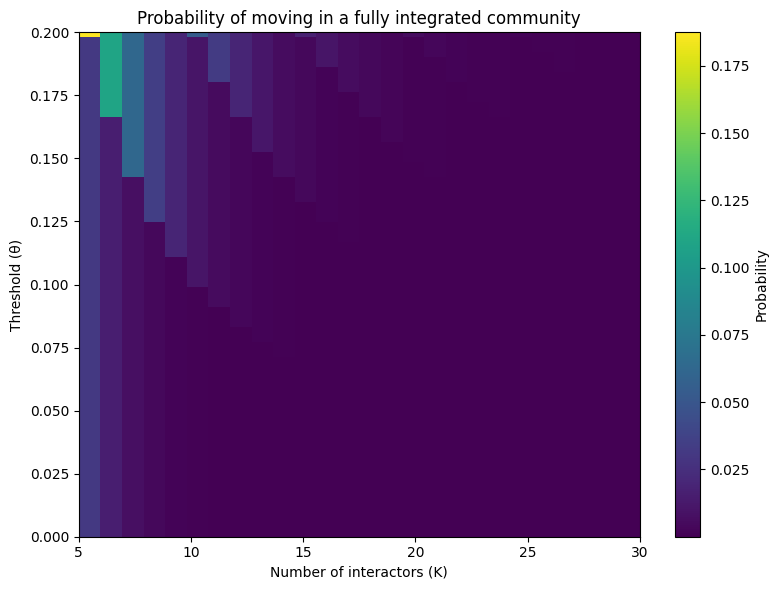

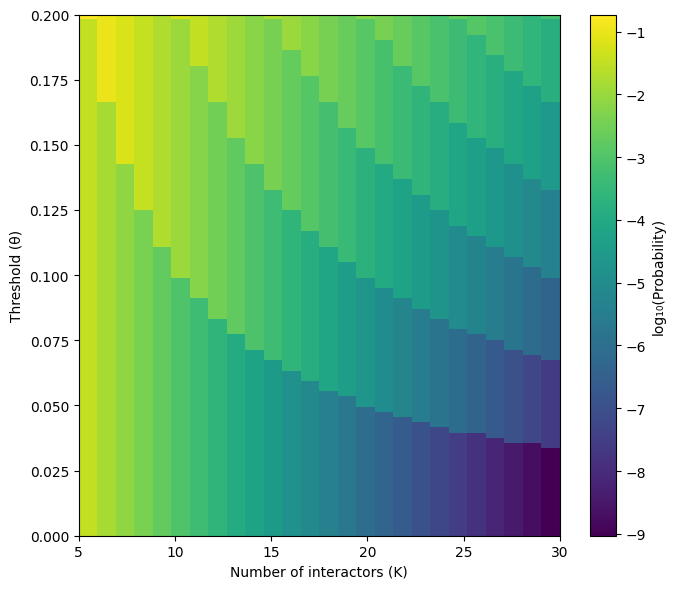

In [67]:
# Zoom in on relevant theta and k

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom

# Define a range of K (number of tosses) and P (percentage threshold for heads)
K_values = np.arange(5, 31)  # Number of coin tosses from 1 to 50
P_percentages = np.linspace(0, 20, 101)/100  # Threshold percentage from 0% to 50%

# Create a grid of probabilities
prob_matrix = np.zeros((len(P_percentages), len(K_values)))

for i, P in enumerate(P_percentages):
    for j, K in enumerate(K_values):
        threshold = int(np.floor(P * K))  # Max number of heads allowed
        prob_matrix[i, j] = binom.cdf(threshold, K, 0.5)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6))
c = ax.imshow(prob_matrix, aspect='auto', origin='lower',
              extent=[K_values[0], K_values[-1], P_percentages[0], P_percentages[-1]],
              cmap='viridis')
ax.set_xlabel('Number of interactors (K)')
ax.set_ylabel('Threshold (θ)')
ax.set_title('Probability of moving in a fully integrated community')
fig.colorbar(c, ax=ax, label='Probability')
plt.tight_layout()
plt.show()


# Create a new plot using log scale for probabilities
fig, ax = plt.subplots(figsize=(7, 6))

# Use log10 scale, but avoid log(0) by setting a very small minimum value
log_prob_matrix = np.log10(np.maximum(prob_matrix, 1e-10))

c = ax.imshow(log_prob_matrix, aspect='auto', origin='lower',
              extent=[K_values[0], K_values[-1], P_percentages[0], P_percentages[-1]],
              cmap='viridis')
ax.set_xlabel('Number of interactors (K)')
ax.set_ylabel('Threshold (θ)')

fig.colorbar(c, ax=ax, label='log₁₀(Probability)')
plt.tight_layout()
plt.savefig('fig3_zoomed.png',dpi=300)
plt.savefig('fig3_zoomed.pdf',dpi=300)
plt.show()